Convolutional neural networks appear to be wildly successful at image recognition tasks, but they are far from perfect despite their success in this area. They are known to be susceptible to attacks called adversarial examples, in which an image that is clearly of one class to a human observer can be imperceptably modified in such a way that the neural network begins to misclassify the example when a human would not.

In this post  will explore the topic of adversrial examples using the [Convolutional Neural Network I created for a Kaggle competition](http://everettsprojects.com/2018/01/13/MNIST-CNN.html) and then later [visualized](http://everettsprojects.com/2018/01/17/mnist-visualization.html). To do so I will use new hand drawn digits that the neural network has never seen before, and show that the neural network correctly classifies them. I will then use a library called [CleverHans](https://github.com/tensorflow/cleverhans) to compute the necessary perturbations to push the model into classifing that digit as each of the other nine possible digits. These perturbed examples will be visualized to show that the changes required for misclassification are often not as significant as you might expect.

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd

'''
Split the provided training data to create a new training
data set and a new validation data set. These will be used
or hyper-parameter tuning.
'''

# For reproducibility
seed = 27

raw_data = pd.read_csv("input/train.csv")

train, validate = train_test_split(raw_data, test_size=0.1, random_state = seed, stratify = raw_data['label'])

# Split into input (X) and output (Y) variables
x_validation = validate.values[:,1:].reshape(4200,28,28, 1)
y_validation = validate.values[:,0]

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import numpy as np
import keras
from keras import backend
from keras.models import load_model
import tensorflow as tf
from tensorflow.python.platform import flags

from cleverhans.utils_mnist import data_mnist
from cleverhans.utils_tf import model_train, model_eval
from cleverhans.attacks import FastGradientMethod
from cleverhans.utils import AccuracyReport
from cleverhans.utils_keras import cnn_model
from cleverhans.utils_keras import KerasModelWrapper

# Set the learning phase to false, the model is pre-trained.
backend.set_learning_phase(False)
keras_model = load_model('models/Jan-13-2018.hdf5')

/home/everett/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
testing = False
train_start = 0
train_end = 60000
test_start = 0
test_end=10000
batch_size = 512

# Object used to keep track of (and return) key accuracies
report = AccuracyReport()

# Set TF random seed to improve reproducibility
tf.set_random_seed(1234)

if not hasattr(backend, "tf"):
    raise RuntimeError("This tutorial requires keras to be configured"
                       " to use the TensorFlow backend.")

if keras.backend.image_dim_ordering() != 'tf':
    keras.backend.set_image_dim_ordering('tf')
    print("INFO: '~/.keras/keras.json' sets 'image_dim_ordering' to "
          "'th', temporarily setting to 'tf'")

# Retrieve the tensorflow session
sess =  backend.get_session()

# Define input TF placeholder
x = tf.placeholder(tf.float32, shape=(None, 28, 28, 1))
y = tf.placeholder(tf.float32, shape=(None, 10))

# Evaluate the model's accuracy on the validation data used in training
x_validation = x_validation.astype('float32')
x_validation /= 255

pred = np.argmax(keras_model.predict(x_validation), axis = 1)
validation_accuracy =  np.mean(np.equal(pred, y_validation))

print("The normal validation accuracy is: {}".format(validation_accuracy))

The normal validation accuracy is: 0.9973809523809524


In [7]:
# Initialize the Fast Gradient Sign Method (FGSM) attack object and 
# use it to create adversarial examples as numpy arrays.
wrap = KerasModelWrapper(keras_model)
fgsm = FastGradientMethod(wrap, sess=sess)
fgsm_params = {'eps': 0.3,
               'clip_min': 0.,
               'clip_max': 1.}
adv_x = fgsm.generate_np(x_validation, **fgsm_params)

adv_pred = np.argmax(keras_model.predict(adv_x), axis = 1)
adv_accuracy =  np.mean(np.equal(adv_pred, y_validation))

print("The adversarial validation accuracy is: {}".format(adv_accuracy))

The adversarial validation accuracy is: 0.2007142857142857


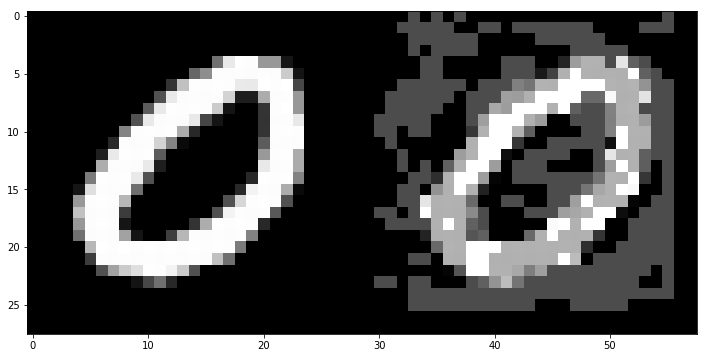

In [33]:
from matplotlib import pyplot as plt

# Set the matplotlib figure size
plt.rc('figure', figsize = (12.0, 12.0))

# Dimensions of the images
img_width = 28
img_height = 28

# Define a function that stitches the 28 * 28 numpy arrays
# together into a collage.
def stitch_images(images, y_img_count, x_img_count):
    margin = 2
    width = y_img_count * img_width + (y_img_count - 1) * margin
    height = x_img_count * img_height + (x_img_count - 1) * margin
    stitched_images = np.zeros((width, height))

    # Fill the picture with our saved filters
    for i in range(y_img_count):
        for j in range(x_img_count):
            img = images[i * x_img_count + j]
            stitched_images[(img_width + margin) * i: (img_width + margin) * i + img_width,
                            (img_height + margin) * j: (img_height + margin) * j + img_height] = img

    return stitched_images

x_sample = x_validation[4].reshape(28, 28)
adv_x_sample = adv_x[4].reshape(28, 28)

adv_comparison = stitch_images([x_sample, adv_x_sample], 1, 2)

plt.imshow(adv_comparison, cmap = 'gray')
plt.show()

In [34]:
print(np.argmax(keras_model.predict(x_sample.reshape(1, 28, 28, 1)), axis = 1))
print(np.argmax(keras_model.predict(adv_x_sample.reshape(1, 28, 28, 1)), axis = 1))

[0]
[9]
